# Variational Quantum Deflation (VQD) Algorithm 

This notebook demostrates how to use Qiskit's implementation of the [Variational Quantum Deflation (VQD)](https://qiskit.org/documentation/stubs/qiskit.algorithms.eigensolvers.VQD.html) algorithm for computing higher energy states of a Hamiltonian, as introduced in this [reference paper](https://arxiv.org/abs/1805.08138). 

## Introduction

VQD is a quantum algorithm that uses a variational technique to find the *k* eigenvalues of the Hamiltonian *H* of a given system.
    
The algorithm computes excited state energies of generalized hamiltonians by optimizing over a modified cost function. Each successive eigenvalue is calculated iteratively by introducing an overlap term with all the previously computed eigenstates that must be minimized. This ensures that higher energy eigenstates are found.

## Complete working example for VQD

The first step of the VQD workflow is to create a qubit operator, ansatz and optimizer. For this example, you can use the H2 molecule, which should already look familiar if you have completed the previous VQE tutorials:

In [1]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

You can set up, for example, a `TwoLocal` ansatz with three qubits, and choose `SLSQP` as the optimization method.

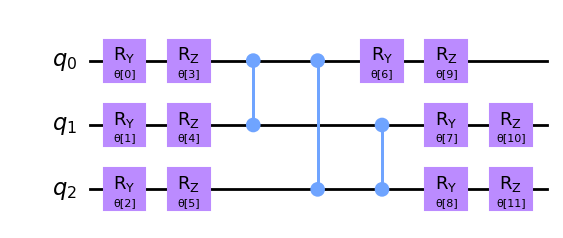

In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SLSQP

ansatz = TwoLocal(3, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

optimizer = SLSQP()
ansatz.decompose().draw('mpl')

The next step of the workflow is to define the required primitives for running `VQD`. This algorithm requires two different primitive instances: one `Estimator` for computing the expectation values for the "VQE part" of the algorithm, and one `Sampler`. The sampler will be passed along to the `StateFidelity` subroutine that will be used to compute the cost for higher energy states. There are several methods that you can use to compute state fidelities, but to keep things simple, you can use the `ComputeUncompute` method already available in `qiskit.algorithm.state_fidelities`.

In [3]:
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute

estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

In order to set up the VQD algorithm, it is important to define two additional inputs: the number of energy states to compute (`k`) and the `betas` defined in the original VQD paper. In this example, the number of states (`k`) will be set to three, which indicates that two excited states will be computed in addition to the ground state.

The `betas` balance the contribution of each overlap term to the cost function, and they are an optional argument in the `VQD` construction. If not set by the user, they can be autoevaluated for input operators of type `SparsePauliOp`. Please note that if you want to set your own `betas`, you should provide a list of values of length `k`.

In [4]:
k = 3
betas = [33, 33, 33]

You are almost ready to run the VQD algorithm, but let's define a callback first to store intermediate values:

In [5]:
counts = []
values = []
steps = []

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

You can finally instantiate `VQD` and compute the eigenvalues for the chosen operator.

In [6]:
from qiskit.algorithms.eigensolvers import VQD


vqd = VQD(estimator, fidelity, ansatz, optimizer, k=k, betas=betas, callback=callback)
result = vqd.compute_eigenvalues(operator = H2_op)
vqd_values = result.eigenvalues


You can see the three state energies as part of the `VQD` result:

In [7]:
print(vqd_values.real)

[-1.83696781 -1.24458427 -0.88272242]


And we can use the values stored by the callback to plot the energy convergence for each state:

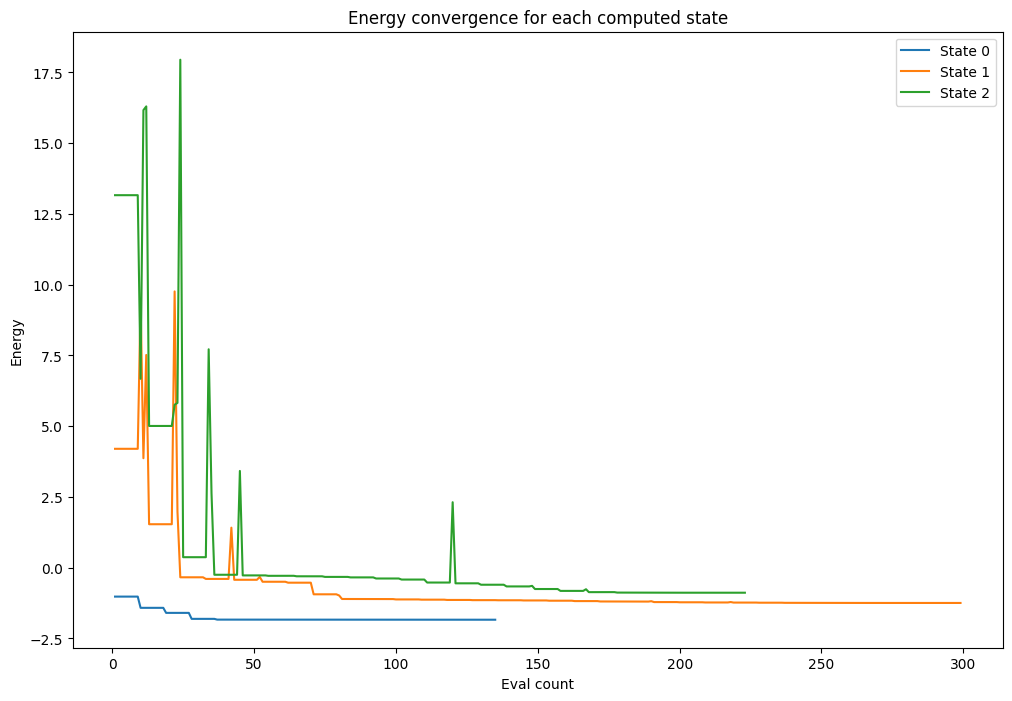

In [8]:
import numpy as np
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)

steps = np.asarray(steps)
counts = np.asarray(counts)
values = np.asarray(values)

for i in range(1,4):
    _counts = counts[np.where(steps == i)]
    _values = values[np.where(steps == i)]
    pylab.plot(_counts, _values, label=f"State {i-1}")
    
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for each computed state")
pylab.legend(loc="upper right");

This molecule can be solved exactly using the `NumPyEigensolver` class, which will give a reference value that you can compare with the `VQD` result:

In [9]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver


exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(H2_op)
ref_values = exact_result.eigenvalues

Let's see a comparison of the exact result with the previously computed `VQD` eigenvalues:

In [10]:
print(f"Reference values: {ref_values}")
print(f"VQD values: {vqd_values.real}")

Reference values: [-1.85727503 -1.24458455 -0.88272215]
VQD values: [-1.83696781 -1.24458427 -0.88272242]


As you can see, the result from VQD matches the values from the exact solution, and extends VQE to also compute excited states. 

In [11]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright